# Modelo de Regresión Logística para Detección de Intrusos en la Red

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Cargar los datos
df = pd.read_excel("Tabla_Intruso_Detectado.xlsx")
df.head()

,ID,FLAG_INTRUSO_DETECTADO,FLAG_IP_EXTRANJERA,MINUTOS_CONEXION,N_CONEXION_U3M
0,1,0,1,13,11
1,2,0,0,14,9
2,3,0,0,10,13
3,4,0,0,9,7
4,5,0,0,10,11


### Definiendo la variable objetivo y las variables predictoras

El objetivo es predecir si se detecta un intruso (FLAG_INTRUSO_DETECTADO, variable binaria), en función de:
- Si la IP es extranjera (FLAG_IP_EXTRANJERA)
- Minutos de conexión (MINUTOS_CONEXION)
- Número de conexiones a la red U3M (N_CONEXION_U3M)

In [4]:
# Definir X (predictoras) e y (objetivo)
X = df[['FLAG_IP_EXTRANJERA', 'MINUTOS_CONEXION', 'N_CONEXION_U3M']]
y = df['FLAG_INTRUSO_DETECTADO']

### Análisis exploratorio preliminar

In [5]:
df.describe()

,ID,FLAG_INTRUSO_DETECTADO,FLAG_IP_EXTRANJERA,MINUTOS_CONEXION,N_CONEXION_U3M
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.00000
mean,5000.50000,0.30000,0.400000,10.800000,10.43000
std,2886.89568,0.45828,0.489922,2.441433,5.15051
min,1.00000,0.00000,0.000000,7.000000,0.00000
25%,2500.75000,0.00000,0.000000,8.750000,6.00000
50%,5000.50000,0.00000,0.000000,11.000000,11.00000
75%,7500.25000,1.00000,1.000000,12.250000,14.00000
max,10000.00000,1.00000,1.000000,15.000000,20.00000


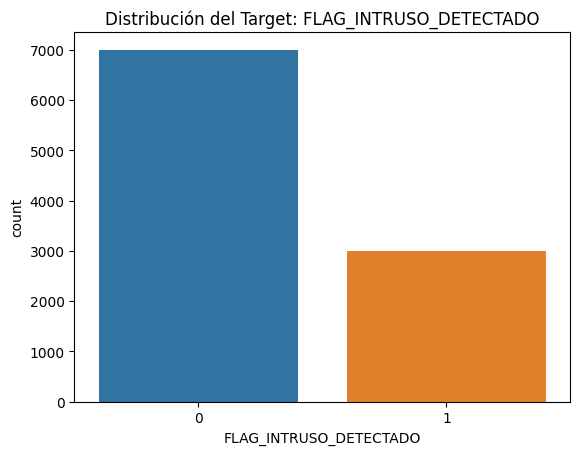

In [6]:
# Ver distribución de la variable objetivo
sns.countplot(x=y)
plt.title("Distribución del Target: FLAG_INTRUSO_DETECTADO")
plt.show()

El gráfico muestra la distribución de la variable objetivo FLAG_INTRUSO_DETECTADO, que indica si se ha detectado un intruso (1) o no (0).
- Aproximadamente el 70% de las observaciones corresponden a casos donde no se detectó un intruso.
- El restante 30% corresponde a casos donde sí se detectó un intruso.

Esto sugiere una ligera desbalanceo en la variable de respuesta, aunque no es extremo. 

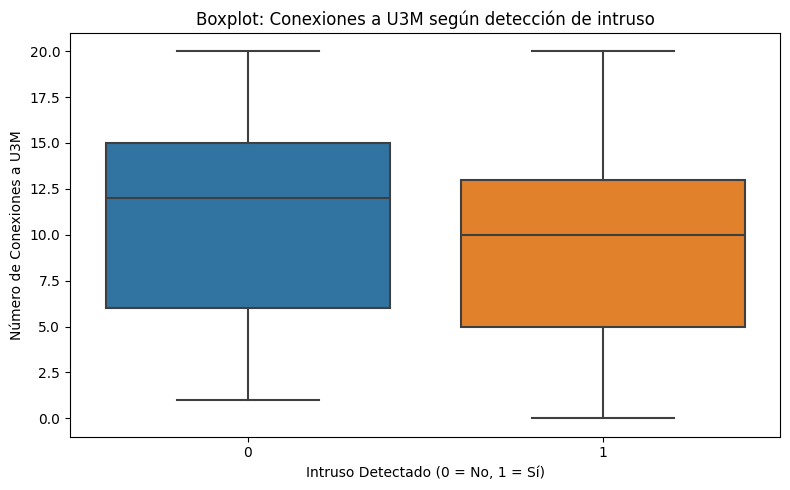

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot de N_CONEXION_U3M por FLAG_INTRUSO_DETECTADO
plt.figure(figsize=(8, 5))
sns.boxplot(x='FLAG_INTRUSO_DETECTADO', y='N_CONEXION_U3M', data=df)
plt.title("Boxplot: Conexiones a U3M según detección de intruso")
plt.xlabel("Intruso Detectado (0 = No, 1 = Sí)")
plt.ylabel("Número de Conexiones a U3M")
plt.tight_layout()
plt.show()

A mayor número de conexiones a la red U3M, parece menos probable que se trate de un intruso.

**Mediana:**
- Los no intrusos (0) tienen una mediana de conexiones mayor (~12).
- Los intrusos (1) tienen una mediana menor (~10).

**Rango intercuartílico (IQR):**
- Ambos grupos comparten un rango similar (aproximadamente entre 5 y 15), pero los no intrusos presentan una mayor concentración en los valores altos.

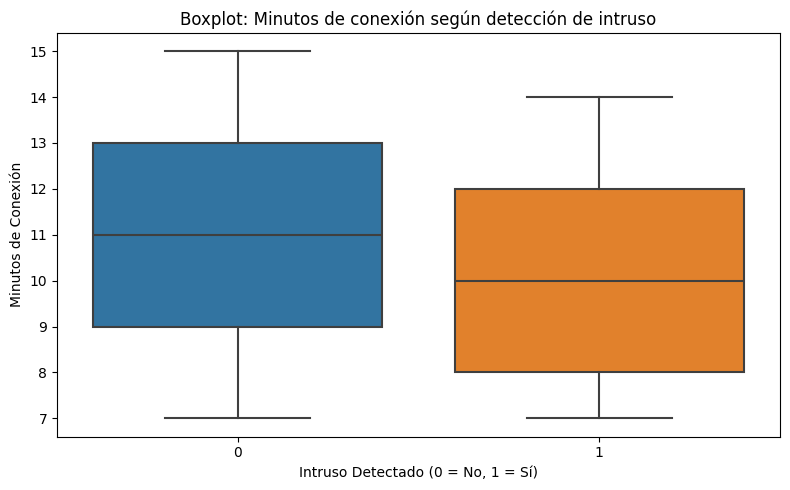

In [8]:
# Boxplot de MINUTOS_CONEXION por FLAG_INTRUSO_DETECTADO
plt.figure(figsize=(8, 5))
sns.boxplot(x='FLAG_INTRUSO_DETECTADO', y='MINUTOS_CONEXION', data=df)
plt.title("Boxplot: Minutos de conexión según detección de intruso")
plt.xlabel("Intruso Detectado (0 = No, 1 = Sí)")
plt.ylabel("Minutos de Conexión")
plt.tight_layout()
plt.show()

Los usuarios identificados como intrusos tienden a tener sesiones de conexión más cortas que los usuarios regulares.

**Mediana:**
- Los no intrusos (0) tienen una mediana más alta, cerca de 11 minutos.
- Los intrusos (1) tienen una mediana de conexión cercana a 10 minutos.

**Rango intercuartílico (IQR):**
- Los no intrusos tienden a conectarse entre ~9 y ~13 minutos.
- Los intrusos se conectan entre ~8 y ~12 minutos.

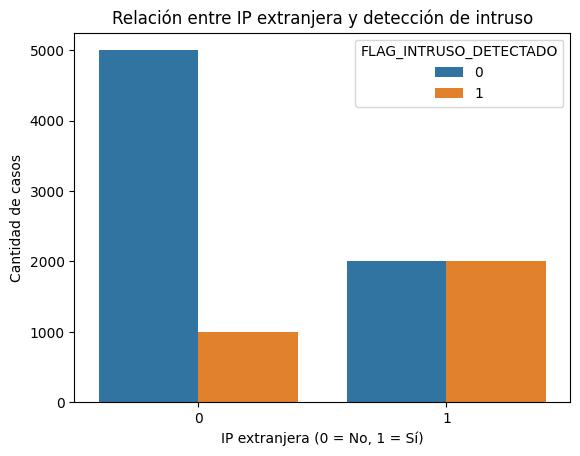

In [9]:
sns.countplot(x='FLAG_IP_EXTRANJERA', hue='FLAG_INTRUSO_DETECTADO', data=df)
plt.title("Relación entre IP extranjera y detección de intruso")
plt.xlabel("IP extranjera (0 = No, 1 = Sí)")
plt.ylabel("Cantidad de casos")
plt.show()

Tener una IP extranjera incrementa notablemente la probabilidad de ser clasificado como intruso.

**Casos con IP nacional (FLAG_IP_EXTRANJERA = 0):**
- La mayoría no fueron intrusos (~5000 casos).
- Un grupo menor (~1000 casos) sí fue detectado como intruso.

**Casos con IP extranjera (FLAG_IP_EXTRANJERA = 1):**
- La distribución se divide prácticamente en partes iguales (~2000 no intrusos vs ~2000 intrusos).

## Preprocesamiento de datos

In [10]:
from sklearn.preprocessing import StandardScaler

# Selección de variables
X = df[['FLAG_IP_EXTRANJERA', 'MINUTOS_CONEXION', 'N_CONEXION_U3M']]
y = df['FLAG_INTRUSO_DETECTADO']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [11]:
scaler = StandardScaler()
cols_to_scale = ['MINUTOS_CONEXION', 'N_CONEXION_U3M']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

## Entrenamiento del modelo logístico 

In [12]:
import statsmodels.api as sm

In [13]:
modelo = LogisticRegression(
    class_weight='balanced',
    penalty='l1',
    solver='liblinear'
)
modelo.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

### Evaluación del modelo

In [14]:
y_pred = modelo.predict(X_test_scaled)

In [15]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.8423    0.7505    0.7938      2100
           1     0.5359    0.6722    0.5964       900

    accuracy                         0.7270      3000
   macro avg     0.6891    0.7113    0.6951      3000
weighted avg     0.7504    0.7270    0.7345      3000



In [ ]:
import numpy as np

precision = np.zeros(100)
recall = np.zeros(100)
thresholds = np.linspace(0, 1, 100)

# Calcular F1 para cada punto (excepto último)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # evitar división por cero

# O filtrar los válidos
valid = ~np.isnan(f1_scores[:-1])
best_index = np.argmax(f1_scores[:-1][valid])
best_threshold = thresholds[valid][best_index]
best_f1 = f1_scores[:-1][valid][best_index]

print(f"Mejor umbral: {best_threshold:.4f} con F1-score: {best_f1:.4f}")

NameError: name 'precision' is not defined

In [ ]:
y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Reporte de Clasificación (umbral = 0.6502234419538228):
              precision    recall  f1-score   support

           0     0.8369    0.8405    0.8387      2100
           1     0.6240    0.6178    0.6209       900

    accuracy                         0.7737      3000
   macro avg     0.7305    0.7291    0.7298      3000
weighted avg     0.7730    0.7737    0.7733      3000



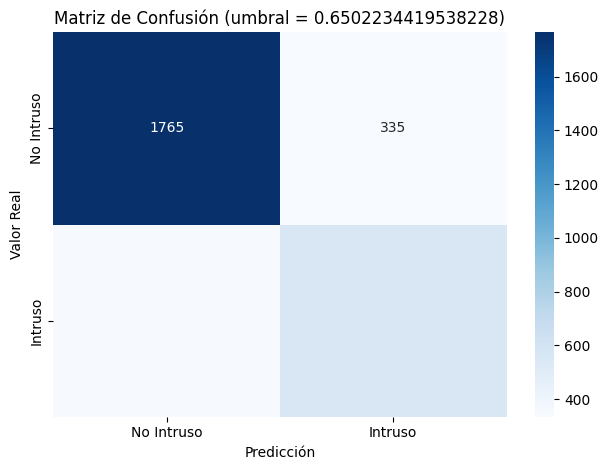

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Reporte de Clasificación (umbral = {best_threshold}):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Intruso', 'Intruso'],
            yticklabels=['No Intruso', 'Intruso'])
plt.title(f"Matriz de Confusión (umbral = {best_threshold})")
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

In [ ]:
for threshold in [0.5, 0.4, 0.35, 0.3, 0.25]:
    y_pred_umbral = (y_pred_proba >= threshold).astype(int)
    print(f"\n--- Umbral: {threshold} ---")
    print(classification_report(y_test, y_pred_umbral, digits=4))


--- Umbral: 0.5 ---
              precision    recall  f1-score   support

           0     0.8423    0.7505    0.7938      2100
           1     0.5359    0.6722    0.5964       900

    accuracy                         0.7270      3000
   macro avg     0.6891    0.7113    0.6951      3000
weighted avg     0.7504    0.7270    0.7345      3000


--- Umbral: 0.4 ---
              precision    recall  f1-score   support

           0     0.8473    0.5338    0.6550      2100
           1     0.4162    0.7756    0.5417       900

    accuracy                         0.6063      3000
   macro avg     0.6318    0.6547    0.5983      3000
weighted avg     0.7180    0.6063    0.6210      3000


--- Umbral: 0.35 ---
              precision    recall  f1-score   support

           0     0.8548    0.4710    0.6073      2100
           1     0.3972    0.8133    0.5337       900

    accuracy                         0.5737      3000
   macro avg     0.6260    0.6421    0.5705      3000
weighted a

In [ ]:
print("Intrusos reales en test:", sum(y_test == 1))
print("Total casos en test:", len(y_test))

Intrusos reales en test: 900
Total casos en test: 3000


In [ ]:
# Mostrar algunas probabilidades generadas por el modelo
import pandas as pd

probas = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1
df_pred = pd.DataFrame({
    'y_real': y_test.values,
    'proba_intruso': probas
})

# Ver los casos donde el valor real es 1
df_intrusos = df_pred[df_pred['y_real'] == 1]

# Mostrar los percentiles de probabilidad
print("Percentiles de probabilidad para intrusos reales:")
print(df_intrusos['proba_intruso'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

Percentiles de probabilidad para intrusos reales:
count    864.000000
mean       0.600619
std        0.195713
min        0.216010
25%        0.458787
50%        0.665357
75%        0.758890
90%        0.788883
95%        0.805966
max        0.813128
Name: proba_intruso, dtype: float64


In [ ]:
# Mostrar los coeficientes beta
coeficientes = modelo.coef_[0]
variables = X_train_scaled.columns
for var, beta in zip(variables, coeficientes):
    print(f"{var}: β = {beta:.4f}")

NameError: name 'modelo' is not defined

In [ ]:
importancia = pd.DataFrame({
    'Variable': variables,
    'Beta': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values(by='Importancia_Abs', ascending=False)

print("\nImportancia relativa de las variables (según |β|):")
print(importancia)

# Gráfico de importancia
sns.barplot(x='Importancia_Abs', y='Variable', data=importancia)
plt.title("Importancia de Variables según coeficientes (|β|)")
plt.xlabel("Importancia absoluta")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

- El modelo identificó correctamente 1910 usuarios reales no intrusos como no intrusos.
- El modelo marcó 226 usuarios inocentes como intrusos, lo cual puede ser un problema si el sistema genera alarmas.